In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
import seaborn as sns

from snntorch.spikegen import rate, latency

ModuleNotFoundError: No module named 'snntorch'

In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Raw

We use a packaged version of the YingYang Dataset, availbale at https://github.com/GabrielBena/yin_yang_data_set

In [3]:
from yingyang.dataset import YinYangDataset

In [4]:
train_dataset = YinYangDataset(size=1000, seed=42)
test_dataset = YinYangDataset(size=1000, seed=44)

### Encoding data
we need to encode the raw data to create spikes during the appropriate amount of timesteps. We use a first-spike encoding, with a minimum and maximum timestep of spiking

In [5]:
dt = 1e-3
t_per_sample = 50e-3
steps_per_pass = int(t_per_sample / dt)

In [6]:
def encode_data(data, T, t_min, t_max=None, use_snntorch=False):
    if not isinstance(data, torch.Tensor):
        data = torch.from_numpy(data)

    if not use_snntorch:
        if t_max is None:
            t_max = int(T * 4 / 5)
        spike_data = t_min + (t_max - t_min) * (data < 0.5).reshape(data.shape[0], -1)
        spike_data = F.one_hot(spike_data, int(T)).transpose(2, 1)
    else:
        spike_data = (
            latency(
                data,
                T,
                first_spike_time=t_min,
                normalize=True,
                linear=True,
                interpolate=False,
            )
            .flatten(start_dim=2)
            .transpose(0, 1)
        )

    return spike_data  # n_samples x T x n_in

In [7]:
spiking_data_train = encode_data(
    train_dataset.data, steps_per_pass, t_min=2, use_snntorch=True
)
spiking_data_test = encode_data(
    test_dataset.data, steps_per_pass, t_min=2, use_snntorch=True
)

In [8]:
timesteps = steps_per_pass
tau_syn = 5e-3
tau_mem = 20e-3

neuron_params = {
    "threshold": 1.0,
    "i_offset": 0.0,
    "reset": "reset_to_v_reset",
    "dt": dt,
    "tau_mem": tau_mem,
    "tau_syn": tau_syn,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from eventprop.models import SNN, SpikeCELoss

In [30]:
model_config = {
    "T": timesteps,
    "dt": dt,
    "tau_m": tau_mem,
    "tau_s": tau_syn,
    "scale": 5.5,
    "resolve_silent": False,
    "device": device,
    "get_first_spikes": False,
    "model_type": "eventprop",
    "reset_to_zero": True,
    "seed": 42,
    "init_mode": "kaiming_both",
}



In [32]:
dims = [4, 30, 3]

eventprop_model = SNN(dims, **model_config).to(device)
# dict(eventprop_model.named_parameters())["layers.0.weight"].T
loss_fn = SpikeCELoss()
optimizer = torch.optim.Adam(eventprop_model.parameters(), lr=0.0685)

In [33]:
eventprop_model.layers[0].weight.T

tensor([[ 4.1160,  2.3698,  4.5311,  6.9383,  2.1061,  2.1061,  7.0928,  4.8604,
          1.4589,  4.2420,  1.4756,  1.4692,  3.4154, -2.5115, -1.9935,  1.2037,
         -0.0353,  3.6142,  0.2529, -1.1338,  6.7805,  2.1291,  2.9357, -1.1681,
          1.2529,  3.0550, -0.4152,  3.7832,  1.0982,  1.9478],
        [ 1.0953,  7.8438,  2.7129, -0.1587,  5.0120, -0.6073,  3.3244, -2.6391,
         -0.9025,  3.2914,  4.7808,  3.2213,  2.4320,  1.9220, -1.3159,  0.7704,
          1.4832,  5.6571,  3.6950, -2.0984,  3.6412,  1.6910,  0.8885,  4.4321,
          5.5852,  5.3110,  0.4422,  1.8997,  3.6610,  5.4327],
        [ 1.4323,  2.2394, -0.2924, -0.5396,  4.9844,  6.4797,  2.5520,  5.5097,
          3.7445,  0.9759,  3.7438,  6.9796,  2.6515,  7.0528, -4.4543,  5.0102,
          2.9894,  1.9277,  3.0023, -2.7158,  2.1459,  3.7321,  6.8142,  1.3248,
          0.5266,  1.3702,  5.2674,  3.6541,  1.2932,  4.1615],
        [ 3.0170,  5.4138,  0.8194,  1.8489,  1.6717, -1.2747,  3.5643,  3.4679

In [13]:
data = spiking_data_test[0].to(device).unsqueeze(1)
target = torch.tensor([test_dataset.targets[0]]).to(device)
out = eventprop_model(data)
out[0].retain_grad()
loss = loss_fn(out[0], target)
print(loss)

(tensor(0.7177, device='cuda:0', grad_fn=<NllLossBackward0>), tensor([[34., 34., 37.]], device='cuda:0', grad_fn=<FirstSpikeTimeBackward>))


In [14]:
def plot_recs() : 
    n_layers = len(eventprop_model.layers)
    fig, axs = plt.subplots(
        n_layers,
        2,
        figsize=(10, 3 * n_layers),
        sharex=True,
        sharey=False,
        constrained_layout=True,
        dpi=300,
    )
    try:
        axs[0]
    except TypeError:
        axs = np.array(axs)[None, :]

    for r, (rec, axs_rec) in enumerate(zip(["V", "I"], axs.T)):
        for l, ax in enumerate(axs_rec):
            voltages = out[1][rec][l][:, 0].cpu().detach().numpy()
            out_spikes = out[1]["spikes"][l][:, 0].cpu().detach().numpy()
            sns.lineplot(voltages, palette="viridis", ax=ax)
            if rec == "V":
                sns.scatterplot(
                    x=np.where(out_spikes)[0],
                    y=np.ones_like(np.where(out_spikes)[0]),
                    ax=ax,
                    color="black",
                )
            ax.set_title(f" {rec}  : Layer {l}")
            ax.legend().remove()

In [15]:
train_accs, test_accs = [], []
for epoch in range(10):
    [accs.append([]) for accs in [train_accs, test_accs]]
    for batch in range(10):

        data, label = spiking_data_test[batch * 10 : batch * 10 + 10].to(
            device
        ).transpose(0, 1), torch.tensor(
            test_dataset.targets[batch * 10 : batch * 10 + 10]
        ).to(
            device
        )

        out = eventprop_model(data)
        loss, first_spikes = loss_fn(out[0], label)
        test_accs[-1].append((first_spikes.argmin(1) == label).cpu().data.float().mean().data.item())

        data, label = spiking_data_train[batch * 10 : batch * 10 + 10].to(
            device
        ).transpose(0, 1), torch.tensor(
            train_dataset.targets[batch * 10 : batch * 10 + 10]
        ).to(
            device
        )

        out = eventprop_model(data)
        loss, first_spikes = loss_fn(out[0], label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_accs[-1].append((first_spikes.argmin(1) == label).cpu().data.float().mean().data.item())

In [57]:
dims = [4, 20, 3]

eventprop_model = SNN(dims, **model_config).to(device)
# dict(eventprop_model.named_parameters())["layers.0.weight"].T
loss_fn = SpikeCELoss()
optimizer = torch.optim.Adam(eventprop_model.parameters(), lr=0.0685)

In [64]:
batch_size = 20
offset = 40

data = spiking_data_train[offset:batch_size+offset].to(device).transpose(0, 1)
target = torch.tensor(train_dataset.targets[offset:batch_size+offset]).to(device)
out = eventprop_model(data)
out[0].retain_grad()
loss, first_spikes = loss_fn(out[0], target)
print(loss, first_spikes)
optimizer.zero_grad()
loss.backward()
# optimizer.step()


tensor(1.9505, device='cuda:0', grad_fn=<NllLossBackward0>) tensor([[19., 21., 20.],
        [28., 29., 29.],
        [26., 34., 34.],
        [28., 31., 31.],
        [30., 32., 30.],
        [18., 22., 22.],
        [27., 29., 29.],
        [27., 30., 29.],
        [19., 21., 41.],
        [29., 31., 30.],
        [30., 32., 31.],
        [17., 18., 19.],
        [25., 27., 32.],
        [28., 31., 31.],
        [28., 31., 31.],
        [19., 23., 21.],
        [28., 29., 29.],
        [24., 27., 26.],
        [24., 27., 26.],
        [24., 30., 27.]], device='cuda:0', grad_fn=<FirstSpikeTimeBackward>)


In [63]:
first_spikes

tensor([[22., 23., 35.],
        [17., 21., 20.],
        [29., 30., 29.],
        [22., 23., 24.],
        [27., 29., 29.],
        [29., 30., 30.],
        [26., 29., 29.],
        [28., 30., 29.],
        [17., 20., 20.],
        [28., 30., 30.],
        [20., 21., 22.],
        [18., 20., 20.],
        [30., 31., 31.],
        [30., 30., 30.],
        [29., 31., 30.],
        [28., 30., 29.],
        [20., 24., 22.],
        [19., 43., 22.],
        [27., 29., 32.],
        [17., 20., 19.]], device='cuda:0', grad_fn=<FirstSpikeTimeBackward>)

In [56]:
{n : p.grad for n,p in eventprop_model.named_parameters()}["layers.0.weight"].T.data.cpu().numpy()[:, -10:]

array([[-2.38e-06,  0.00e+00, -9.70e-05,  0.00e+00,  0.00e+00,  4.14e-04,
         0.00e+00, -4.49e-04,  0.00e+00, -1.62e-04],
       [-6.54e-06,  0.00e+00, -5.40e-05,  0.00e+00,  0.00e+00,  6.24e-04,
         0.00e+00, -2.50e-04,  0.00e+00, -9.35e-05],
       [ 0.00e+00,  0.00e+00, -2.96e-05,  0.00e+00,  0.00e+00,  0.00e+00,
         0.00e+00, -1.37e-04,  0.00e+00,  0.00e+00],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
         0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00]], dtype=float32)

In [19]:
np.set_printoptions(precision=2)
{n : p.grad for n,p in eventprop_model.named_parameters()}["layers.1.weight"].T.data.cpu().numpy()

array([[ 6.86e-05, -3.08e-04,  5.12e-05],
       [-3.00e-05, -4.59e-04, -9.63e-05],
       [-3.00e-05, -2.33e-04, -1.58e-04],
       [-8.45e-05,  9.22e-05, -1.43e-04],
       [-7.04e-05, -3.39e-04,  7.35e-05],
       [ 0.00e+00,  0.00e+00,  0.00e+00],
       [-1.16e-04,  9.29e-05, -1.73e-04],
       [ 4.81e-05, -7.50e-06, -6.24e-05],
       [ 0.00e+00,  0.00e+00,  0.00e+00],
       [-1.16e-04,  7.00e-06, -8.54e-05]], dtype=float32)

In [20]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
dict(eventprop_model.named_parameters())["layers.1.weight"].T

tensor([[ 3.0236,  2.0373,  1.5381],
        [ 1.2156, -0.8323,  0.4873],
        [ 0.9381,  3.5779,  2.3369],
        [-1.3271,  2.3029,  1.0695],
        [ 0.5619,  2.8031,  3.5324],
        [ 3.3590,  0.2796,  1.2015],
        [ 2.3154,  3.4360,  0.9058],
        [ 1.4163, -0.1849, -0.3413],
        [ 3.1524,  4.0981,  1.6140],
        [ 3.4847,  2.3682,  0.6172]], device='cuda:0',
       grad_fn=<PermuteBackward0>)

In [ ]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
dict(eventprop_model.named_parameters())["layers.1.weight"].T

tensor([[ 3.0236,  2.0373,  1.5381],
        [ 1.1471, -0.9008,  0.5558],
        [ 0.8696,  3.5779,  2.4054],
        [-1.3956,  2.2344,  1.1380],
        [ 0.4934,  2.8031,  3.6009],
        [ 3.3590,  0.2796,  1.2015],
        [ 2.2469,  3.3675,  0.9743],
        [ 1.4163, -0.1849, -0.3413],
        [ 3.1524,  4.0981,  1.6140],
        [ 3.4162,  2.3682,  0.6857]], device='cuda:0',
       grad_fn=<PermuteBackward0>)

In [ ]:
loss.backward()
{n : p.grad for n,p in eventprop_model.named_parameters()}["layers.1.weight"].T

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.8805e-05,  1.2876e-04, -4.5862e-04],
        [ 4.1629e-05,  0.0000e+00, -3.4857e-04],
        [ 5.8895e-05,  3.4758e-04, -6.2802e-04],
        [ 3.1640e-05,  0.0000e+00, -1.9918e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.8895e-05,  3.4758e-04, -6.2802e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.1629e-05,  0.0000e+00, -3.4857e-04]], device='cuda:0')

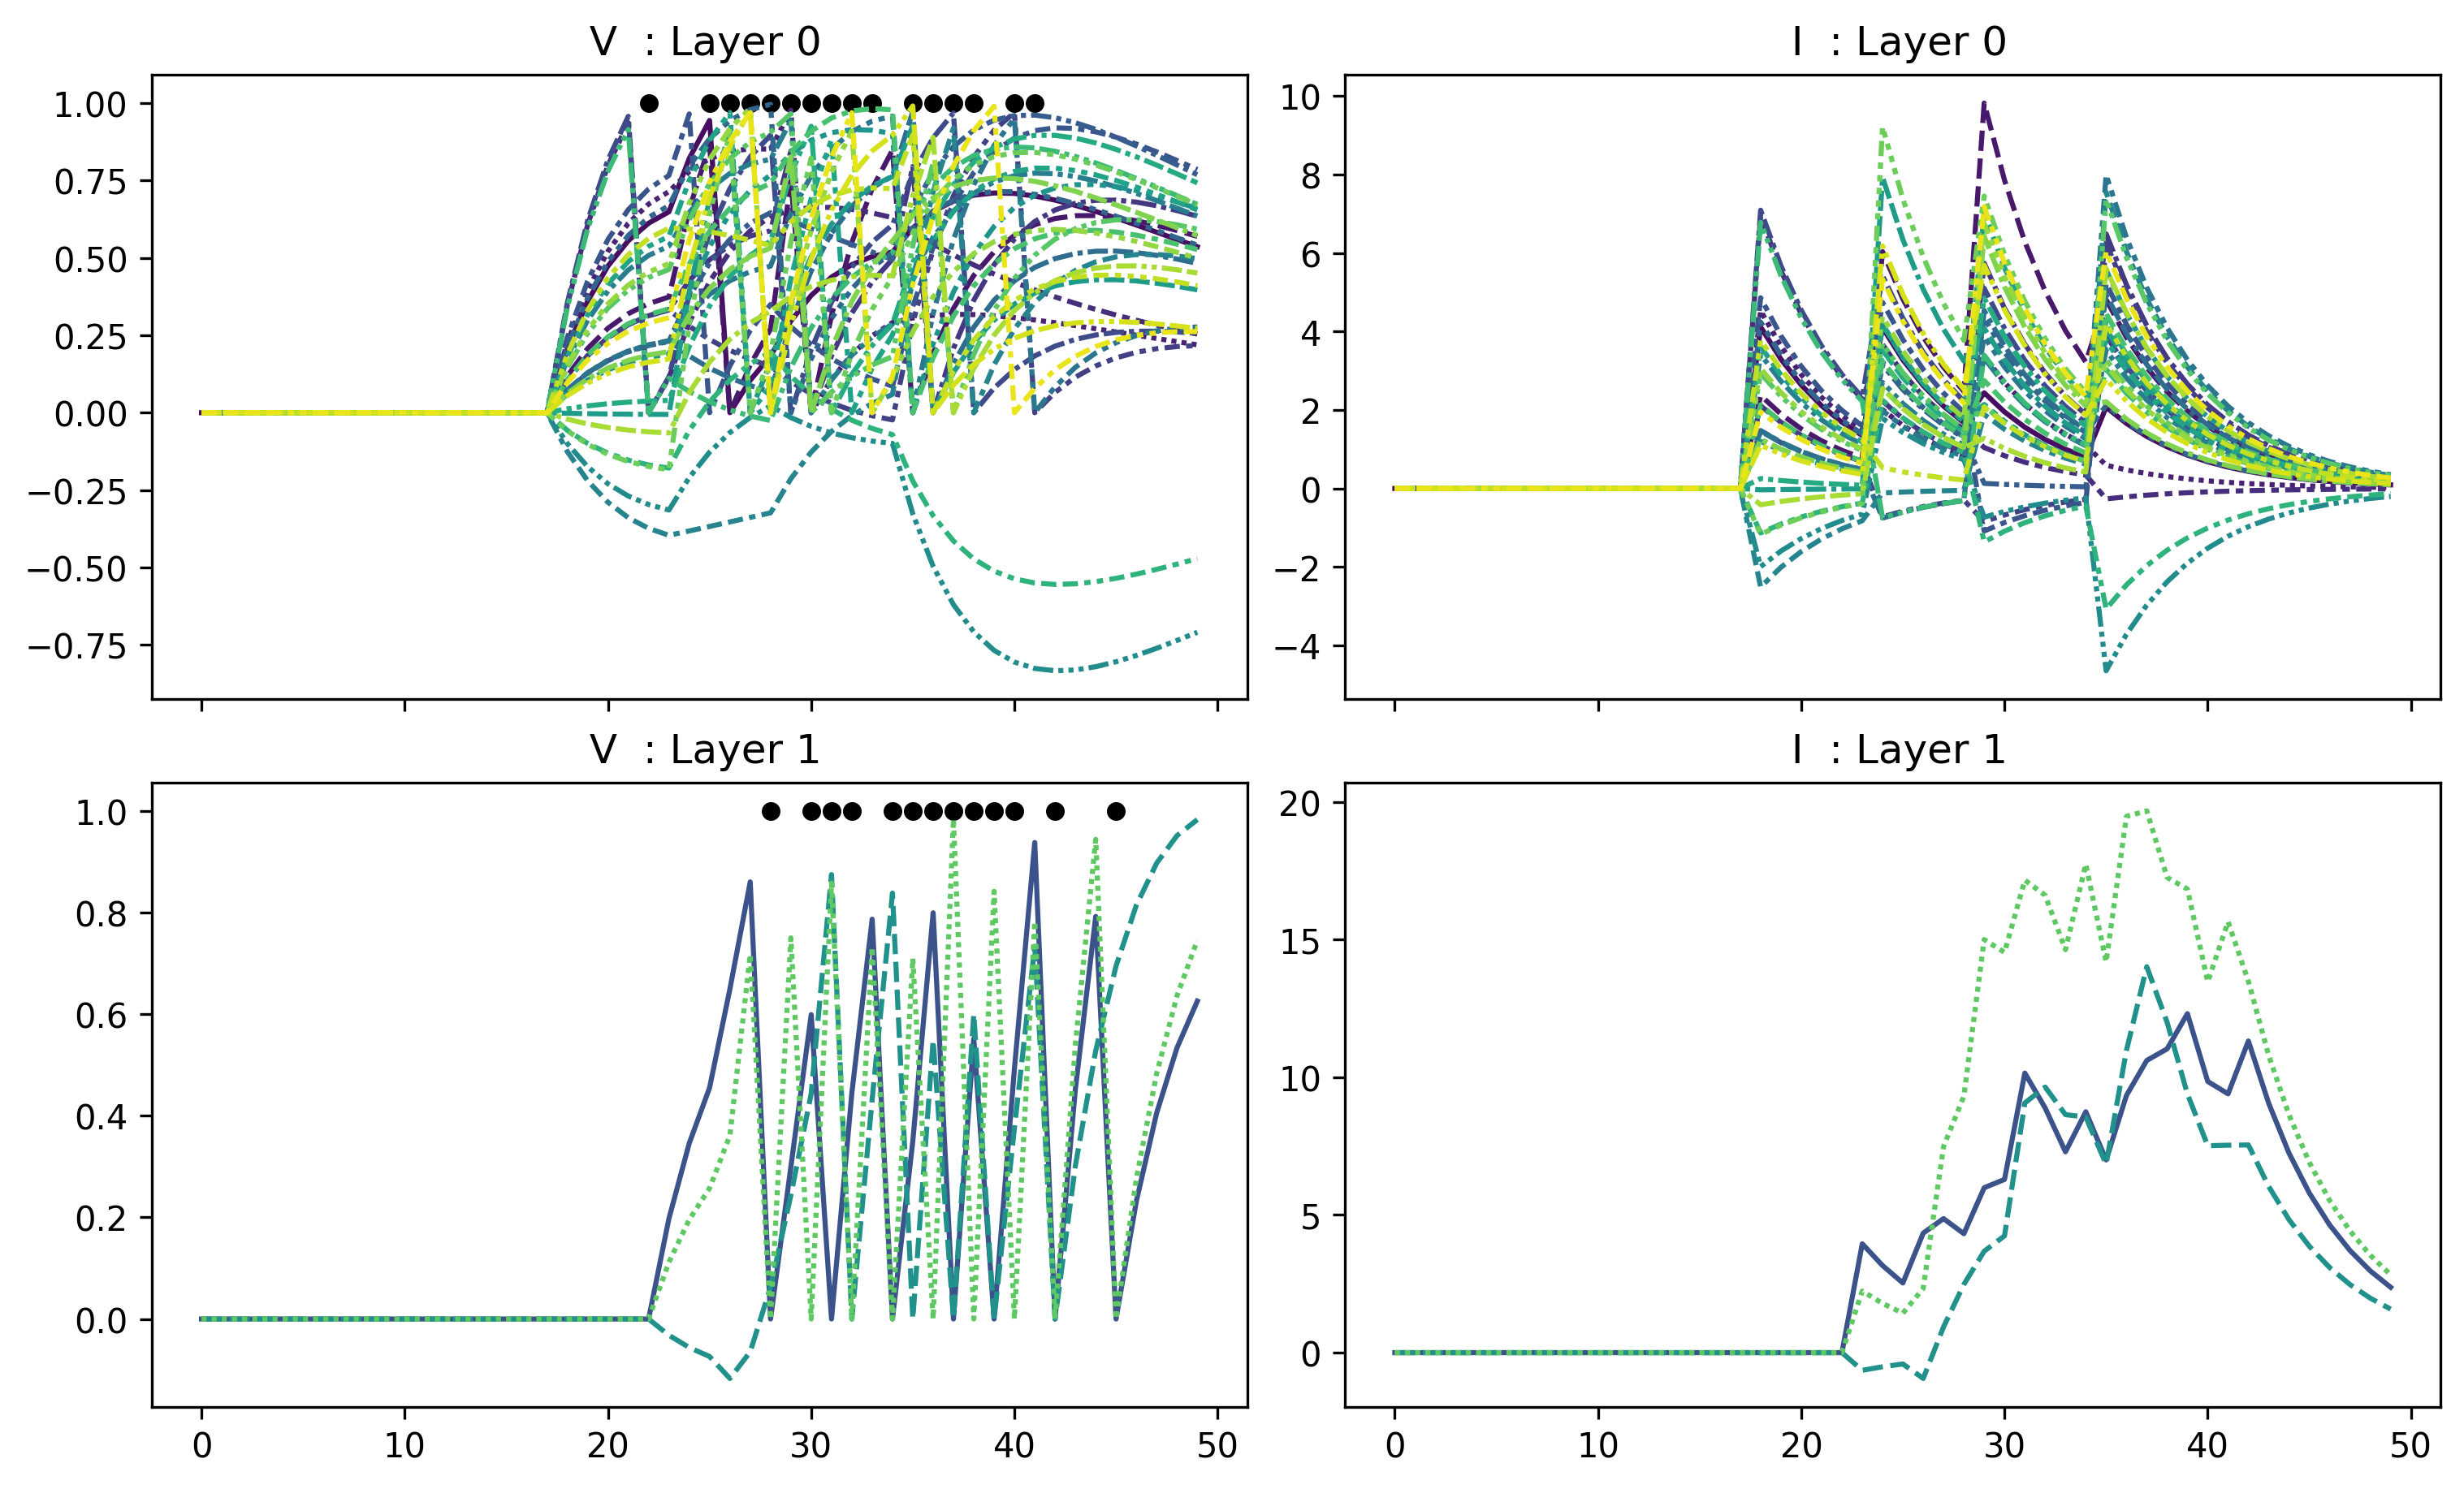

In [ ]:
n_layers = len(eventprop_model.layers)
fig, axs = plt.subplots(
    n_layers,
    2,
    figsize=(10, 3 * n_layers),
    sharex=True,
    sharey=False,
    constrained_layout=True,
    dpi=300,
)
try:
    axs[0]
except TypeError:
    axs = np.array(axs)[None, :]

for r, (rec, axs_rec) in enumerate(zip(["V", "I"], axs.T)):
    for l, ax in enumerate(axs_rec):
        voltages = out[1][rec][l][:, 0].cpu().detach().numpy()
        out_spikes = out[1]["spikes"][l][:, 0].cpu().detach().numpy()
        sns.lineplot(voltages, palette="viridis", ax=ax)
        if rec == "V":
            sns.scatterplot(
                x=np.where(out_spikes)[0],
                y=np.ones_like(np.where(out_spikes)[0]),
                ax=ax,
                color="black",
            )
        ax.set_title(f" {rec}  : Layer {l}")
        ax.legend().remove()